In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw, rdprops, rdcompare, rdconvert, rdtypes

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

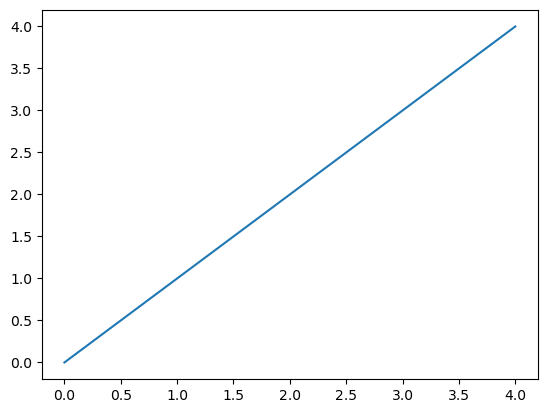

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(5)
plt.plot(x)

In [3]:

ff_name = 'openff-2.0.0.offxml'
src = ps.OPENFF_DIR / ff_name
dest = Path.cwd() / ff_name
copyfile(src, dest)

PosixPath('/home/timber/Documents/Python/openff-workspace/polymer_workspace/openff-2.0.0.offxml')

## Building long polymers for Connor

In [ ]:
from polysaccharide.polymer import building, monomer, filtering

COLL_PATH = Path('Collections')

coll_name_1 = 'simple_polymers'
target_polymers = (
    'polyethylene',
    'polyethylmethacrylate',
    'naturalrubber',
    'polyphenylenesulfone',
    'polyvinylchloride',
    'atactic_styrene',
    'syntactic_styrene',
    'bisphenolA_modified',
    'polymethylketone'
)

to_reverse = {
    'bisphenolA_modified'   : True,
    'polymethylketone'      : False,
    'polyvinylchloride'     : False,
    'polyethylene'          : False,
    'atactic_styrene'       : True,
    'polyphenylenesulfone'  : False,
    'syntactic_styrene'     : False,
    'naturalrubber'         : False,
    'polyethylmethacrylate' : True,
    'paam_modified'         : True,
    'pnipam_modified'       : True,
    'peg_modified'          : True
}

mgr_1 = PolymerManager(COLL_PATH / coll_name_1)
is_target = filtering.filter_factory_by_attr(attr_name='mol_name', condition=lambda name : name in target_polymers)

coll_name_2 = 'water_soluble_polymers'
mgr_2 = PolymerManager(COLL_PATH / coll_name_2)

polymers = {**mgr_1.filtered_by(is_target), **mgr_2.polymers}
polymers.keys()

In [ ]:
parent_dir = Path('long_linear_polymers')
parent_dir.mkdir(exist_ok=True)

for order in (3, 4, 5):
    targ_size = int(10**order)
    outpath = parent_dir / f'linear_polymers_{targ_size}'
    outpath.mkdir(exist_ok=True)

    size_dict = {}
    for mol_name, polymer in polymers.items():
        monomer_info = polymer.monomer_info
        smarts = monomer_info.SMARTS
        print(mol_name)

        try:
            thresh_DOP = monomer.estimate_DOP_lower(smarts, max_chain_len=targ_size)
            N = monomer.estimate_chain_len(smarts, DOP=thresh_DOP + 1)
            # print(thresh_DOP, N, monomer.is_linear(smarts), monomer.is_homopolymer(smarts))

            new_poly = building.build_linear_polymer(smarts, DOP=thresh_DOP + 1, add_Hs=False, reverse_term_labels=to_reverse[mol_name])
            # display(Chem.MolFromSmiles(new_poly.to_smiles()))
            size_dict[mol_name] = N

            save_strpath = general.asstrpath(outpath / f'{mol_name}.pdb')
            new_poly.save(save_strpath)
        except Exception as e:
            print('FAILED', type(e), e, '\n')

    inventory = pd.DataFrame(size_dict.items(), columns=['Molecule', 'Chain Length'])
    inventory.to_csv(outpath / f'Inventory_{targ_size}')

polyethylmethacrylate


[10:30:11] Explicit valence for atom # 4 O, 3, is greater than permitted


None

bisphenolA_modified


[10:30:14] Explicit valence for atom # 4275 O, 3, is greater than permitted


None

polyphenylenesulfone


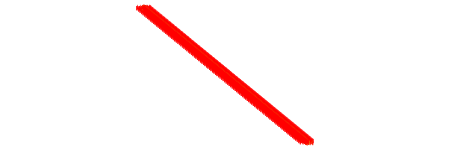

naturalrubber


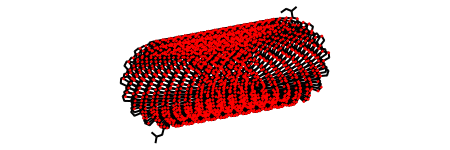

atactic_styrene


ValueError: Too many rings open at once. SMILES cannot be generated.

paam_modified


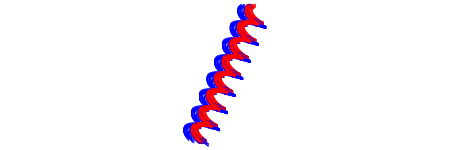

polyvinylchloride


[10:32:11] Cannot determine element for PDB atom #4701


None

peg_modified


[10:32:15] Explicit valence for atom # 1565 O, 3, is greater than permitted


None

syntactic_styrene


[10:32:21] Explicit valence for atom # 0 C, 5, is greater than permitted


None

pnipam_modified


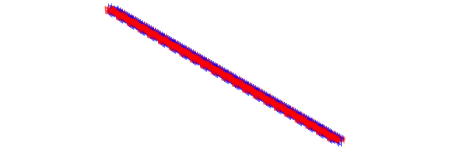

polyethylene


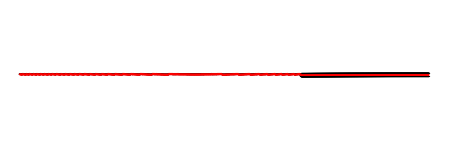

In [12]:
parent_dir = Path('long_linear_polymers')
targ_dir = parent_dir / 'linear_polymers_10000'

failed = []
# pdb_path = targ_dir / 'bisphenolA_modified.pdb'
for pdb_path in targ_dir.glob('*.pdb'):
    print(pdb_path.stem)
    rdmol = Chem.MolFromPDBFile(str(pdb_path))
    if rdmol is None:
        failed.append(pdb_path.stem)

    display(rdmol)
    print('='*50)

In [13]:
failed

['polyethylmethacrylate',
 'bisphenolA_modified',
 'polyvinylchloride',
 'peg_modified',
 'syntactic_styrene']

## Running component scripts commands

In [ ]:
# Source collection / structure directory
strct_name = 'simple_polymers'
# strct_name = 'water_soluble_polymers_confs'
# strct_name = 'water_soluble_polymers_equil'

COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs_updated')

pdb_path  = COMPAT_PDB_PATH / strct_name / f'{strct_name}_structures'
mono_path = COMPAT_PDB_PATH / strct_name / f'{strct_name}_monomers'
src_path   = COLL_PATH / strct_name

pdb_str = str(pdb_path)
mono_str = str(mono_path)
src_str = str(src_path)

# Defining control arguments
setup_kwargs = {
    'reset' : False,
    'purge_sims' : False,
    'purge_logs' : False
}
solvate = not True

# Solvent parameters
desired_solvents = ('WATER_TIP3P',) # (None,)
solv_template    = 'solv_polymer_template_box.inp'
exclusion = 1.0*nanometer

# Parsing args for bash digest
arg_str = ' '.join(f'--{arg_name}'
    for arg_name, should_apply in setup_kwargs.items()
        if should_apply
)
solv_str = ' '.join(desired_solvents)

In [ ]:
# Setup, and optionally solvate
%run -i 'setup_collection.py' -out $src_str -pdb $pdb_str -mono $mono_str $arg_str
if solvate:
    %run -i 'polymer_master.py' -src=$src_str 'solvate' -s=$solv_str -pt=$solv_template -e=$exclusion._value --molecules 'polyvinylchloride' 'polythiophene' 'naturalrubber'

In [ ]:
# Charge, simulate, and analyze select trajectories
mgr = PolymerManager(COLL_PATH / 'simple_polymers')
targ_mols = ['polyvinylchloride']#, 'naturalrubber']
mol_str = ' '.join(targ_mols)

%run -i 'polymer_master.py' -src=$src_str 'charge' -cp='standard_chg_params' --molecules $mol_str --solvent
%run -i 'polymer_master.py' -src=$src_str 'simulate' -sp 'equilibration' --molecules $mol_str --solvent
# %run -i 'polymer_master.py' -src=$src_str 'simulate' -sp 'debug_sim_NPT' --molecules $mol_str --solvent
%run -i 'polymer_master.py' -src=$src_str 'analyze' --molecules $mol_str --solvent

## Investigating water underspecification after equilibration

In [ ]:
mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
pdir = mgr.polymers['peg_modified_conf_1_solv_water']

In [ ]:
import MDAnalysis as mda
from polysaccharide.molutils.pdb import pdb_water_atoms_to_hetatoms

pdb_dir = Path('trans_pdb')
pdb_dir.mkdir(exist_ok=True)

traj = pdir.load_traj(remove_solvent=False)
conf = traj[-1]
conf.save_pdb(pdb_dir / 'mdt_struct.pdb')
pdb_water_atoms_to_hetatoms(pdb_dir / 'mdt_struct.pdb', output_path=pdb_dir / 'mdt_struct_het.pdb')

sim_paths, sim_params = pdir.load_sim_paths_and_params()
u = mda.Universe(pdir.structure_file, sim_paths.trajectory)

u.trajectory[-1]
poly_box = u.select_atoms('all')
poly_box.write(pdb_dir / 'mda_struct.pdb')
pdb_water_atoms_to_hetatoms(pdb_dir / 'mda_struct.pdb', output_path=pdb_dir / 'mda_struct_het.pdb')

In [ ]:
from openff.toolkit.topology.topology import UnmatchedAtomsError

tops = {}
pdb_paths = [Path(i) for i in ('mdt_struct.pdb', 'mdt_struct_het.pdb','mda_struct.pdb', 'mda_struct_het.pdb')]

for pdb_path in pdb_paths:
    try:
        tops[pdb_path.stem] = Topology.from_pdb_and_monomer_info(str(pdb_path), monomer_info_json=pdir.monomer_file_uncharged)
    except UnmatchedAtomsError:
        print(f'{pdb_path.stem} failed')

In [ ]:
mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')
pdir = mgr.polymers['pnipam_modified_conf_1_solv_water_equil']
pdir.offmol_matched()

In [ ]:
top, *_ = Topology.from_pdb_and_monomer_info(str(pdb), monomer_info_json=pdir.monomer_file_uncharged, strict=False)

defective = [
    mol for mol in top.molecules
        if not all(atom.metadata['already_matched'] for atom in mol.atoms)
]
len(defective)

In [ ]:
# pdb = pdir.structure_file
pdb = Path('pni.pdb')

rdmol = Chem.MolFromPDBFile(str(pdb), removeHs=False)
frags = Chem.GetMolFrags(rdmol, asMols=True)

for frag in frags[:10]:
    # if frag.GetNumAtoms() == 2:
    display(frag)

In [ ]:
for atom in frags[1].GetAtoms():
    pdb_info = atom.GetPDBResidueInfo()
    print(pdb_info.GetOccupancy())

In [ ]:
topo = pdir.off_topology_matched(strict=False)

defective = []
for mol in topo.molecules:
    if not all(atom.metadata['already_matched'] for atom in mol.atoms):
        defective.append(mol)
len(defective)

## Testing Process workflow

In [ ]:
from polysaccharide.workflow import components as wcomponents
from polysaccharide.workflow.process import Process

chg_params = ChargingParameters.from_file(impres.files(resources.chg_templates) / 'standard_chg_params.json')
sim_params = SimulationParameters.from_file(impres.files(resources.sim_templates) / 'debug_sim_NPT.json')
inp_template = impres.files(resources.inp_templates) / 'solv_polymer_template_box.inp'

proc = Process(
    components=[
        wcomponents.Solvate(solvents=WATER_TIP3P, exclusion=1*nanometer, template_path=inp_template),
        wcomponents.ChargeAssignment(chg_params=chg_params),
        wcomponents.RunSimulations(sim_params=sim_params)
    ],
    proc_name='sim_test'
)
proc, proc.tag

In [ ]:
pdir = mgr.polymers['polyvinylchloride']
logger = logging.getLogger('test')

proc.collated_polymer_fn(pdir, logger)

## Removing fields from XML (useful for annoying barostate in OpenMM states

In [ ]:
import xml.etree.ElementTree as ET

for sim_dir, sim_paths_file in pdir.simulation_paths.items():
    sim_paths = SimulationPaths.from_file(sim_paths_file)
    chk = sim_paths.checkpoint
    if chk.suffix == '.xml':
        tree = ET.parse(sim_paths.checkpoint)
        root = tree.getroot()

        par = next(root.iter('Parameters'))
        par.clear()

## Testing dynamic checkpoint file updating

In [ ]:
import pickle

class Test:
    def __init__(self, val : int, checkpoint : Path) -> None:
        self.val = val
        self.checkpoint_path = checkpoint

    def to_file(self):
        if hasattr(self, 'checkpoint_path'):
            with self.checkpoint_path.open('wb') as file:
                pickle.dump(self, file)

    def __setattr__(self, __name: str, __value: Any) -> None:
        super().__setattr__(__name, __value)
        self.to_file()
        print(__name, __value)

In [ ]:
p = Path('test.pkl')
p.touch()

t = Test(5, p)
t.other = 'word'

In [ ]:
with p.open('rb') as file:
    v = pickle.load(file)

v.__dict__
v.foo = 'bar'

## Experimenting with grid size optimization WRT aspect and number of squares

In [ ]:
from math import ceil, sqrt, floor

def size_penalty(N_targ : int, N_real : int) -> float:
    return (N_real / N_targ - 1)**2

def aspect_penalty(a_targ : float, a_real : float) -> float:
    # return (a_real / a_targ - 1)**2
    return 1 - min(a_targ / a_real, a_real / a_targ)

def dims(N : int, a : float=1/1, w1=1, w2=1) -> tuple[int, int]:
    '''Given a particular number of cells and an aspect ratio, yields the smallest 2x2 grid dimensions which accomodate at least N grid squares whose aspect ratio is closest to the '''
    return min( 
        ((r, ceil(N / r))
            for r in range(1, N + 1)
        ),
        key=lambda dims : w1*size_penalty(N, dims[0]*dims[1]) + w2*aspect_penalty(a, dims[0]/dims[1])
    )

a = 2/1
for N in range(1, 20):
    nrows, ncols = dims(N, a)
    fig, ax = plotutils.presize_subplots(nrows=nrows, ncols=ncols, scale=1)
    fig.suptitle(f'N = {N}')

## Testing PyMBAR timeseries equilibration detection

In [ ]:
from pymbar import timeseries
from polysaccharide.analysis.equilibrium import EQUIL_DETECTOR_REGISTRY
equil_det = EQUIL_DETECTOR_REGISTRY['PyMBAREquilDetector']
# equil_det = EQUIL_DETECTOR_REGISTRY['BinSegEquilDetector']

fast = True

outdir = Path('figures_for_paper/pymbar_equil')
outdir.mkdir(exist_ok=True)

for mol_name, pdir in mgr.filtered_by(is_solvated).items():
    mol_dir = outdir/mol_name
    mol_dir.mkdir(exist_ok=True)

    sim_paths, sim_params = pdir.load_sim_paths_and_params()
    time_df = pd.read_csv(sim_paths.time_data)
    times, time_data = trajectory.props_to_plot_data(time_df)
    times_arr = times.to_numpy()[:, 0]

    fig, ax = plotutils.plot_df_props(times, time_data, df_label='Original samples', elongation=1/2, scale=25)
    for axes, (label, prop_data) in zip(ax.flatten(), time_data.items()):
        prop_data = prop_data.to_numpy()
        t = equil_det.equil_loc(prop_data)
        uncorr_idxs = timeseries.subsample_correlated_data(prop_data, fast=fast)
        t_equil = times_arr[t]

        axes.plot(times_arr[uncorr_idxs], prop_data[uncorr_idxs], label='Uncorrelated samples')
        axes.axvline(t_equil, color='r')
        axes.legend()

    # fig.savefig(mol_dir/f'pymbar_props_{mol_name}.png', bbox_inches='tight')
    # plt.close()

In [ ]:
pdir = mgr.polymers['peg_modified_solv_water']

sim_paths, sim_params = pdir.load_sim_paths_and_params()
state_df = pd.read_csv(sim_paths.state_data)

exclude = ('#"Step"', 'Elapsed Time (s)', 'Speed (ns/day)')
state_df = state_df[[label for label in state_df.columns if label not in exclude]]
state_time, state_data = trajectory.props_to_plot_data(state_df)

fig, ax = plotutils.plot_df_props(state_time, state_data, df_label='test', nrows=2, ncols=3, scale=20)
for axes in ax.flatten():
    axes.legend()

## Generating monomer files for polyamides

In [ ]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

rdkdraw.set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [ ]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

In [ ]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

In [ ]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

rdkdraw.set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Some other section